In [1]:
#Mount GDrive for reading images stored in GDrive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Preparing dataset**

In [ ]:
#unzipping folder in vm
!unzip '/content/gdrive/MyDrive/EE610/LOLdataset.zip' -d /content/dataset

In [6]:
!rm -r /content/dataset/__MACOSX

In [19]:
train_path = './dataset/our485'
# train_labels_path = './dataset/our485/low'
test_path = './dataset/eval15'
# test_labels_path = './dataset/eval15/low'

In [21]:
import os
import cv2

#loading train images
train_imgs = []
train_labels = []

for img_name in os.listdir(os.path.join(train_path,'low')):
  if img_name.startswith('.'):
    continue
  img_path = os.path.join(os.path.join(train_path,'low'),img_name)
  label_path = os.path.join(os.path.join(train_path,'high'),img_name)
  train_imgs.append(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
  train_labels.append(cv2.cvtColor(cv2.imread(label_path), cv2.COLOR_BGR2RGB))

In [22]:
#loading test images
test_imgs = []
test_labels = []

for img_name in os.listdir(os.path.join(test_path,'low')):
  if img_name.startswith('.'):
    continue
  img_path = os.path.join(os.path.join(test_path,'low'),img_name)
  label_path = os.path.join(os.path.join(test_path,'high'),img_name)
  test_imgs.append(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
  test_labels.append(cv2.cvtColor(cv2.imread(label_path), cv2.COLOR_BGR2RGB))

Visualising some training images

In [24]:
# Display images

import matplotlib.pyplot as plt
import numpy as np
import random

n_imgs= 8

plt.figure(figsize = (15,50))
# plt.subplots_adjust(wspace=0.008, hspace=0.005)

for i in range(0, n_imgs*2,2):

    plt.subplot(n_imgs,2,i+1)
    index = random.randint(0,len(train_imgs)-1)
    plt.imshow(train_imgs[index].astype(np.uint8))
    plt.grid('off')
    plt.axis('off')
    plt.title('Original image (low light)')
    
    plt.subplot(n_imgs,2,i+2)
    plt.imshow(train_labels[index].astype(np.uint8))
    plt.grid('off')
    plt.axis('off')
    plt.title('Target enhanced image')


Output hidden; open in https://colab.research.google.com to view.

In [26]:
#Preparing dataset

numPatches = 50 # Number of patches to be extracted from each image
W = 13  #Maximum patch size

X_patch = []  #list of central WxW patches extracted from all training images
Y_central = []

for index,img in enumerate(train_imgs):
  x = random.sample(range(0,img.shape[0]-W+1), numPatches)
  y = random.sample(range(0,img.shape[1]-W +1),numPatches)

  for (i,j) in zip(x,y):
    patch = img[i:i+W,j:j+W]
    X_patch.append(patch)
    Y_central.append((train_labels[index])[i+(W-1)//2,j+(W-1)//2,:])

X_patch = np.asarray(X_patch)
Y_central = np.asarray(Y_central)

# **CNN Model**

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision import utils
import torch.nn as nn
import torch.nn.functional as F

In [28]:
#If want to trai on GPU
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [29]:
#Modified transformation function to convert input to tensor while preparaing batches

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        patch, central_pixel = sample['patch'], sample['central_pixel']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        patch= patch.transpose((2, 0, 1))
        return {'patch': torch.from_numpy(patch),
                'central_pixel': torch.from_numpy(central_pixel)}

In [30]:
#Custom Dataset class

class BSDSDataset(Dataset):

    def __init__(self, patches, central_pixels, transform=None):
        
        self.patches = patches
        self.central_pixels = central_pixels
        self.transform = transform

    def __len__(self):
        return self.central_pixels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        patch = self.patches[idx]
        central_pixel = self.central_pixels[idx]
      
        sample = {'patch': patch, 'central_pixel': central_pixel}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [31]:
#CNN architecture

class MyCNN(nn.Module):

  def __init__(self,w, out_channel1 = 256):

    super(MyCNN, self).__init__()
    self.l1 = nn.Conv2d(3,8,3,padding=1)
    self.l2 = nn.Conv2d(8,16,3, padding=1)
    self.pad1 = nn.ZeroPad2d((0,1,0,1))
    self.pool1 = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear((w+1)*(w+1)*4, out_channel1)
    self.fc2 = nn.Linear(out_channel1,3)

  def forward(self, x):
    
    x = self.l1(x)
    x = F.relu(x)

    x = self.l2(x)
    x = F.relu(x)
    
    x = self.pad1(x)
    x = self.pool1(x)

    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = torch.sigmoid(x)

    return x

  def num_flat_features(self, x):
    size = x.size()[1:]  
    num_features = 1

    for s in size:
      num_features *= s
    return num_features

In [33]:
#evaluation for validation dataset and after each epoch on training dataset

def evaluate(loader, model):
  
  total_loss = 0
  model.eval() 
  with torch.no_grad():

    for sample in loader:

      x = sample['patch'].to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = sample['central_pixel'].to(device=device, dtype=dtype)
      central_preds = model(x)
      num = torch.sqrt((torch.square(central_preds-y).mean(dim = 1)).mean())
      denom = central_preds.mean(dim=1).mean()
      nrmse = num/denom

      total_loss += nrmse.item()

    total_loss /= len(loader)
    
    return total_loss

In [34]:
def train_part(model, optimizer, epochs=1):

  model = model.to(device=device)  
  best_loss = 1e9
  best_model = None   #to store the best model greedy wrt validation loss
  train_losses = []
  val_losses = []

  for e in range(epochs):
    print(f'Epoch = {e+1}')
    
    for t, sample in enumerate(train_loader):

      #training mode
      model.train()  
      
      x = sample['patch'].to(device=device, dtype=dtype)  
      y = sample['central_pixel'].to(device=device, dtype=dtype)
      
      optimizer.zero_grad()

      central_preds = model(x)
      
      #Computing nrmse = rmse/mean of observed data
      num = torch.sqrt((torch.square(central_preds-y).mean(dim = 1)).mean())
      denom = central_preds.mean(dim=1).mean()
      loss = num/denom
      
      #minimising wrt nrmse
      loss.backward()
      optimizer.step()

    train_loss = evaluate(train_loader, model)
    train_losses.append(train_loss)

    print(f'Training loss: {train_loss}')
    
    val_loss = evaluate(val_loader, model)
    val_losses.append(val_loss)

    print(f'Validation loss: {val_loss}')
    print()

    #Update best model           
    if val_losses[-1] < best_loss:
      best_loss = val_losses[-1]
      best_model = model
            
  return train_losses,val_losses,best_loss,best_model

# w = 3

In [35]:
from sklearn.model_selection import train_test_split

#sub-patch size
w = 3
X_patchw = (X_patch[:,(W//2) - (w//2):(W//2) + (w//2)+1,(W//2) - (w//2):(W//2) + (w//2)+1].astype(np.float32))/255
Y_centralw = (Y_central.astype(np.float32))/255

#Train and validation split
X_train_patch, X_val_patch, Y_train_central, Y_val_central = train_test_split(X_patchw, Y_centralw, test_size=0.3, random_state=42)
print(X_train_patch.shape, Y_train_central.shape)


(16975, 3, 3, 3) (16975, 3)


In [36]:
tfm = T.Compose([ToTensor()])

train_dataset = BSDSDataset(X_train_patch, Y_train_central, transform = tfm)
val_dataset = BSDSDataset(X_val_patch, Y_val_central, transform = tfm)

train_loader = DataLoader(train_dataset, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=32)


In [37]:
sample = next(iter(train_loader))
print(sample['patch'].shape)
print(sample['central_pixel'].shape)
# print(sample['central_pixel'])

torch.Size([64, 3, 3, 3])
torch.Size([64, 3])


In [40]:
#Trainging model

model = MyCNN(w = 3)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses,val_losses,best_loss,best_model_3 = train_part(model,opt, epochs = 100)

Epoch = 1
Training loss: 0.33784299618319463
Validation loss: 0.33342867691004485

Epoch = 2
Training loss: 0.32608738339933235
Validation loss: 0.3223649633296749

Epoch = 3
Training loss: 0.32374470787388937
Validation loss: 0.3206742295439829

Epoch = 4
Training loss: 0.32261843923339273
Validation loss: 0.3197994929525936

Epoch = 5
Training loss: 0.3217442766168064
Validation loss: 0.3190153605843845

Epoch = 6
Training loss: 0.32088438920060497
Validation loss: 0.31818117358182607

Epoch = 7
Training loss: 0.3202806461350362
Validation loss: 0.31760765834335697

Epoch = 8
Training loss: 0.3194809136422057
Validation loss: 0.31679983365169745

Epoch = 9
Training loss: 0.3187202935604225
Validation loss: 0.31603199746786503

Epoch = 10
Training loss: 0.3179123316492353
Validation loss: 0.3151965554999678

Epoch = 11
Training loss: 0.3169439583456606
Validation loss: 0.31417066270583555

Epoch = 12
Training loss: 0.3160963101046426
Validation loss: 0.3133022103523999

Epoch = 13
Tra

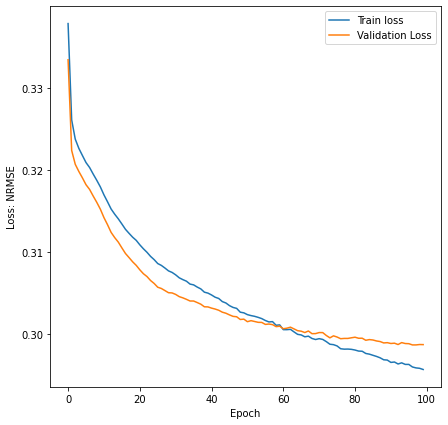

In [41]:
#Plotting trainging and validation lossed
plt.figure(figsize=(7,7))
plt.plot(train_losses)
plt.plot(val_losses)
plt.ylabel('Loss: NRMSE')
plt.xlabel('Epoch')
plt.legend(['Train loss','Validation Loss'])
plt.show()

In [42]:
#Saving best model
model_save_name = 'best_model1.pt'
path = F"/content/gdrive/MyDrive/EE610/{model_save_name}" 
torch.save(best_model_3.state_dict(), path)

In [49]:
#Model prediction on low light image

def enhance_img(llimg, model,w):

  llimg = llimg.astype(np.float32)/255
  #padding width to apply each side
  pad_len = (w-1)//2

  #pad image with zeros
  llpad_img = np.pad(llimg, pad_width=[(pad_len,pad_len),(pad_len,pad_len),(0,0)],mode='constant')

  output_pred = np.zeros((llimg.shape[0],llimg.shape[1],3))

  for i in range(llpad_img.shape[0]-w):
    for j in range(llpad_img.shape[1] - w):

      #get array values in w x w frame
      llimg_patch = llpad_img[i:i+w, j:j+w]
      llimg_patch = llimg_patch.transpose((2,0,1))
      #(1,C,H,W)
      llimg_patch = np.expand_dims(llimg_patch, axis = 0)
      llimg_patch = torch.from_numpy(llimg_patch)

      predict_central_pixel = model(llimg_patch)
      output_pred[i,j,:] = predict_central_pixel.cpu().detach().numpy()

  #bring output in 0-255 integer range
  output_pred = np.clip(output_pred*255,0,255)
  output_pred = np.floor(output_pred).astype(np.uint8)
  return output_pred
      

In [65]:
# Display degraded images

import matplotlib.pyplot as plt
import numpy as np
import random

def display_predictions(best_model,w):
  n_imgs= len(test_imgs)

  plt.figure(figsize = (15,75))
  plt.subplots_adjust(wspace=0.008, hspace=0.005)

  for i in range(0, n_imgs*3,3):

      plt.subplot(n_imgs,3,i+1)
      # index = random.randint(0,len(test_imgs)-1)
      plt.imshow(test_imgs[i//3].astype(np.uint8))
      plt.grid('off')
      plt.axis('off')
      plt.title('Original image (low light)')
      
      plt.subplot(n_imgs,3,i+2)
      plt.imshow(test_labels[i//3].astype(np.uint8))
      plt.grid('off')
      plt.axis('off')
      plt.title('Target enhanced image')

      plt.subplot(n_imgs,3,i+3)
      enh_img = enhance_img(test_imgs[i//3], best_model, w = w)
      # cv2.imwrite('./results' + '/' + str(i//3)+'.png', enh_img[:,:,::-1])
      plt.imshow(enh_img.astype(np.uint8))
      plt.grid('off')
      plt.axis('off')
      plt.title('Enhanced image')


Test results on CNN with w = 3

In [66]:
best_model = MyCNN(w = 3)
model_path = F"/content/gdrive/MyDrive/EE610/best_model1.pt" 
best_model.load_state_dict(torch.load(model_path))
display_predictions(best_model, w = 3)

Output hidden; open in https://colab.research.google.com to view.